In [118]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary
from utils.lick_utils import load_licks, load_licks_video
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
warnings.filterwarnings('ignore')

%matplotlib inline

In [119]:
criteria_name = 'beh_all'
beh_criteria = 'beh_all_beh'
version = 'PrL_S1'
target_folder = '/root/capsule/scratch/manuscript/F_lick_compare'
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [120]:
# load basic constraints and data (unit + behavior)
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# behavior 
with open(os.path.join('/root/capsule/scratch/combined/combined_session_tbl', 'combined_beh_sessions.pkl'), 'rb') as f:
    combined_session_qc = pickle.load(f)
combined_session_qc.drop(columns=['probe'], inplace=True, errors='ignore')
combined_tagged_units = combined_tagged_units.merge(combined_session_qc, on='session', how='left')

# antidromic data
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys_low/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)

with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{beh_criteria}.json'), 'r') as f:
    beh_constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [121]:
# load model results
model_df = pd.read_csv('/root/capsule/scratch/combined/beh_plots/beh_all/figures_in_generation/model_combined_beh_all.csv', index_col=0)
# load basic ephys results
be_criteria = 'basic_ephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', be_criteria)
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

response_tbl = pd.read_csv(f'/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv')
response_tbl['unit_id'] = response_tbl['unit'].apply(to_str_intlike)


Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8327 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8327 -> 5854 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5854 -> 5831 units passed
Applying items for in_df: [True]
 - in_df: 5831 -> 4199 units passed
Applying conditional bounds for y_loc
 - y_loc: 4199 -> 2936 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2936 -> 2922 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 2922 -> 1339 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 298
Number of non-opto rows after filtering: 1339


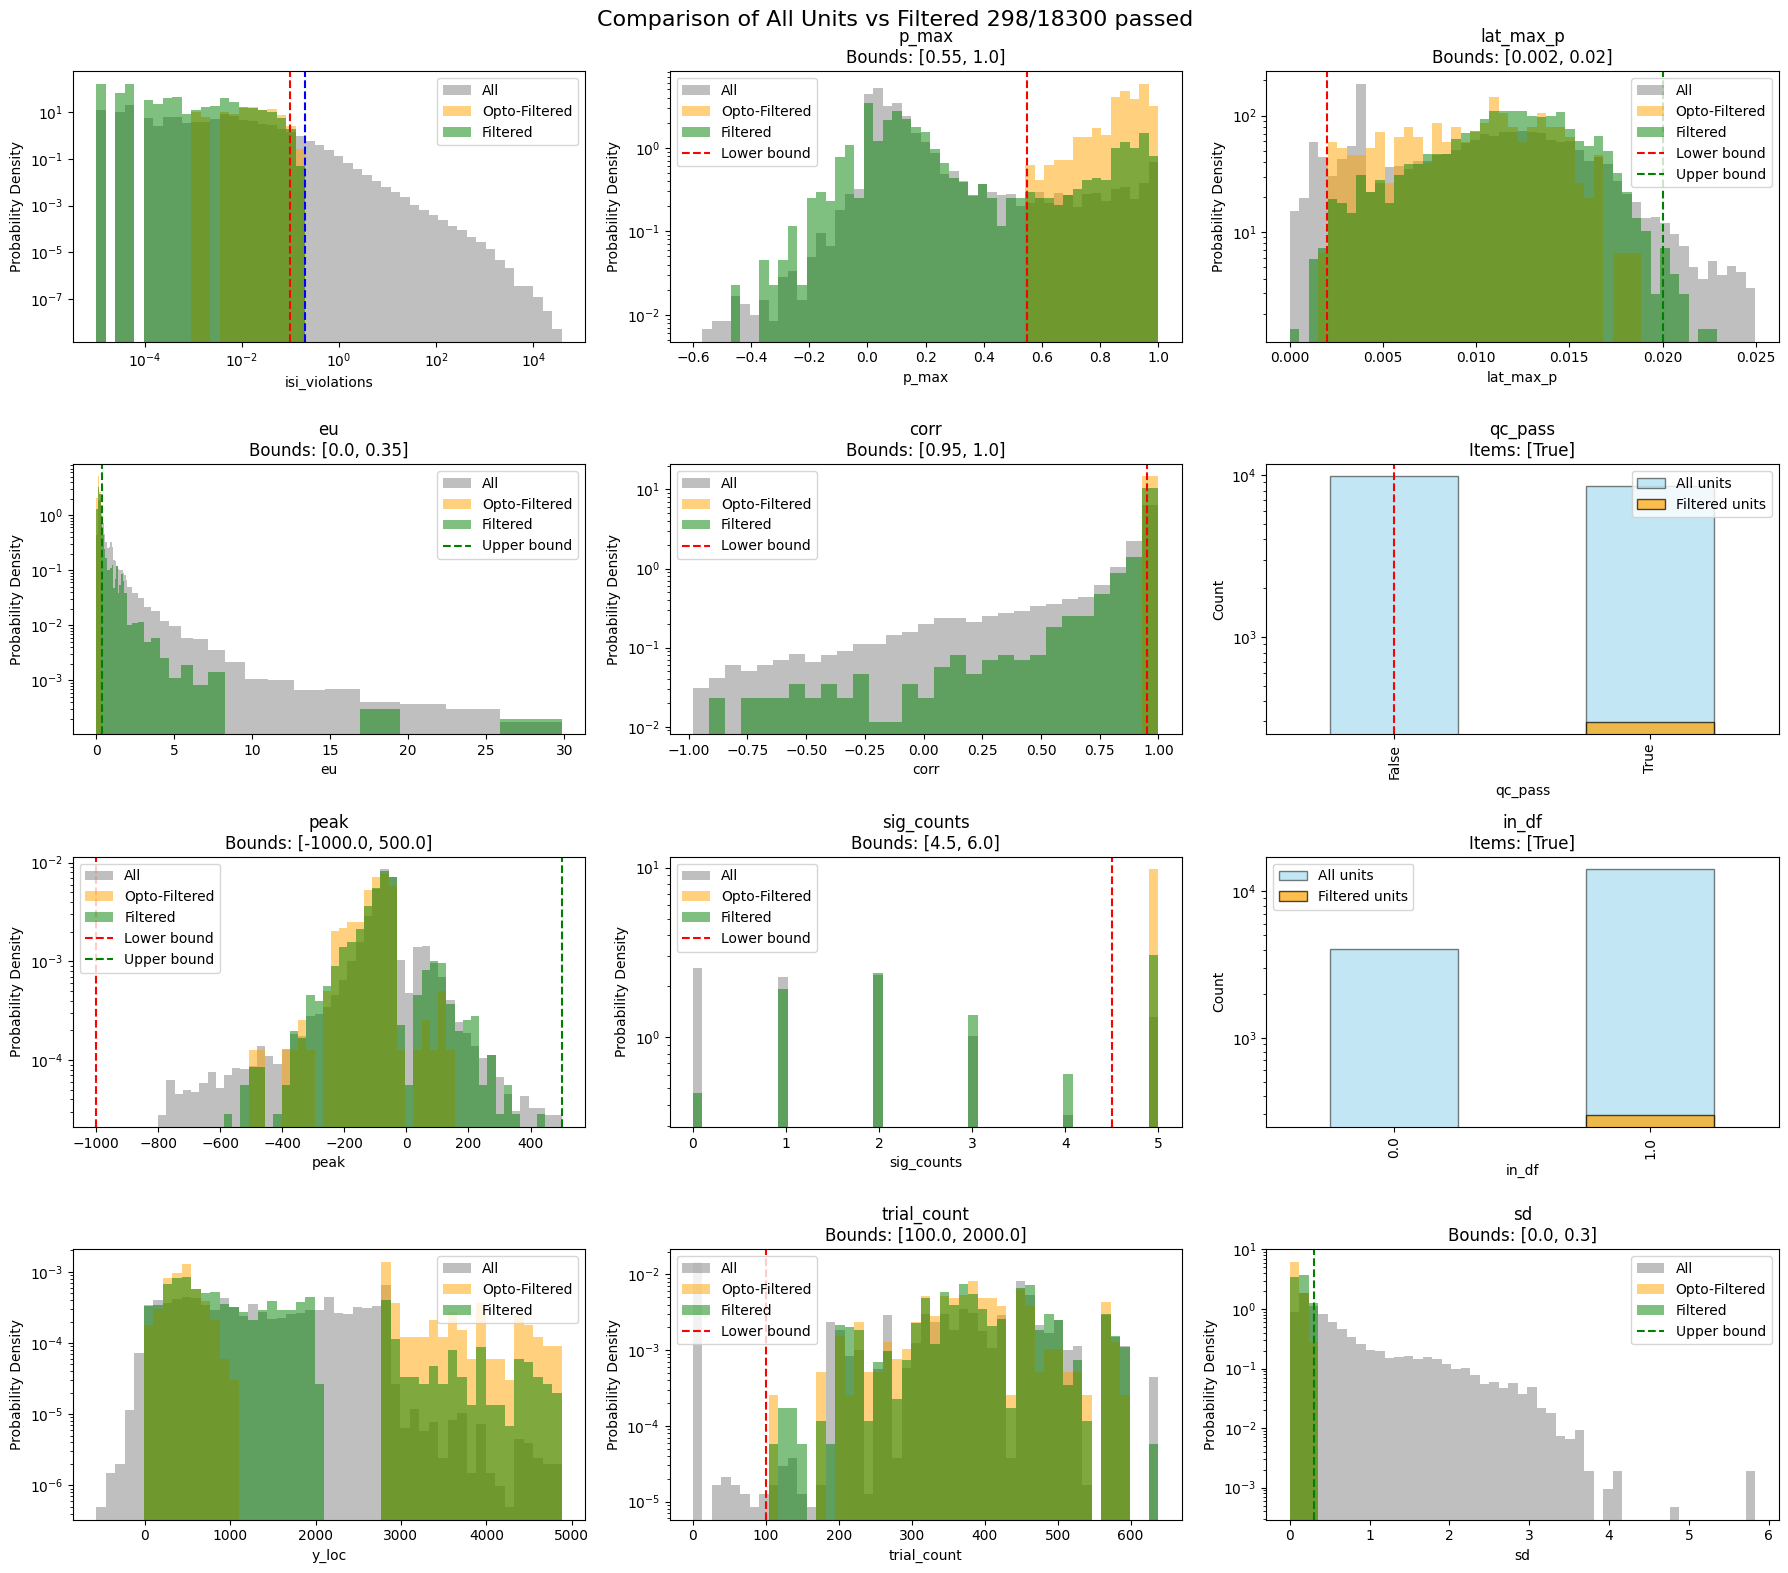

In [122]:
combined_tagged_units_filtered, combined_tagged_units, fig, axes = apply_qc(combined_tagged_units, constraints)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)

In [123]:
def get_lick_psth(session, unit_id):
    bin_size = 0.2
    step_size = 0.05
    tb = -5
    tf = 5
    loaded_session = None
    psth_in_trial = []
    psth_out_trial = []
    in_trial_period = (0, 1.5)
    session_tbl = get_session_tbl(session)
    unit_tbl = get_unit_tbl(session, data_type='curated')
    unit_tbl['unit_id'] = unit_tbl['unit_id'].apply(to_str_intlike)
    licks = load_licks_video(session)
    licks_beh = load_licks(session)
    video_loaded = True
    if licks is None:
        video_loaded = False
        licks = licks_beh


    session_dir = session_dirs(session)
    qm_dir = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
    with open(qm_dir, 'r') as f:
        qm = json.load(f)
    rec_start = qm['ephys_cut'][0]
    rec_end = qm['ephys_cut'][1]
    spike_times = unit_tbl.loc[unit_tbl['unit_id'] == unit_id, 'spike_times'].values[0]
    unit_drift = load_drift(session, unit_id)    
    session_tbl_curr = session_tbl.copy()
    spike_times_curr = spike_times.copy()
    lick_starts_L = licks['lick_trains_L']['train_starts']
    lick_starts_R = licks['lick_trains_R']['train_starts']
    lick_starts_in_trial_L = licks['lick_trains_L']['in_trial']
    lick_starts_in_trial_R = licks['lick_trains_R']['in_trial']
    L_mask = np.ones_like(lick_starts_in_trial_L, dtype=bool)
    R_mask = np.ones_like(lick_starts_in_trial_R, dtype=bool)
    L_mask &= lick_starts_L >= rec_start
    R_mask &= lick_starts_R >= rec_start
    L_mask &= lick_starts_L <= rec_end
    R_mask &= lick_starts_R <= rec_end
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_tbl_curr = session_tbl_curr[session_tbl_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            L_mask &= lick_starts_L >= unit_drift['ephys_cut'][0]
            R_mask &= lick_starts_R >= unit_drift['ephys_cut'][0]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_tbl_curr = session_tbl_curr[session_tbl_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
            L_mask &= lick_starts_L <= unit_drift['ephys_cut'][1]
            R_mask &= lick_starts_R <= unit_drift['ephys_cut'][1]
    lick_starts_L = lick_starts_L[L_mask]
    lick_starts_R = lick_starts_R[R_mask]
    lick_starts_all = np.concatenate([lick_starts_L, lick_starts_R])

    # in trial mask
    in_trial_mask = np.zeros_like(lick_starts_all, dtype=bool)

    for _, trial in session_tbl_curr.iterrows():
        trial_start = trial['goCue_start_time']
        in_trial_mask |= (lick_starts_all >= trial_start+in_trial_period[0]) & (lick_starts_all <= trial_start+in_trial_period[1])
    lick_starts_in_trial = lick_starts_all[in_trial_mask]
    lick_starts_out_trial = lick_starts_all[~in_trial_mask]

    spike_matrix_in, _ = get_spike_matrix(spike_times_curr, lick_starts_in_trial, tb, tf, bin_size, step_size, avoid_overlap = True, kernel=True, tau_rise=0.01, tau_decay=0.08)
    psth_in = np.nanmean(spike_matrix_in, axis=0)

    # has adjacent licks from behavior
    if video_loaded:
        lick_starts_beh = np.concatenate([licks_beh['lick_trains_L']['train_starts'], licks_beh['lick_trains_R']['train_starts']])
        # for lick_starts_all find if there is a beh_lick within 0.2s
        lick_close_beh_mask = np.zeros_like(lick_starts_all, dtype=bool)
        # find distance to closest beh lick
        for i, lick in enumerate(lick_starts_all):
            if len(lick_starts_beh) == 0:
                break
            closest_beh_lick = lick_starts_beh[np.argmin(np.abs(lick_starts_beh - lick))]
            if np.abs(closest_beh_lick - lick) <= 0.2:
                lick_close_beh_mask[i] = True
        lick_starts_out_trial_beh = lick_starts_all[~in_trial_mask & lick_close_beh_mask]
        lick_starts_out_trial_video = lick_starts_all[~in_trial_mask & ~lick_close_beh_mask]
        if len(lick_starts_out_trial_beh) >= 5:
            spike_matrix_out_beh, _ = get_spike_matrix(spike_times_curr, lick_starts_out_trial_beh, tb, tf, bin_size, step_size, avoid_overlap = True, kernel=True, tau_rise=0.01, tau_decay=0.08)
            psth_out_beh = np.nanmean(spike_matrix_out_beh, axis=0)
        else:
            psth_out_beh = np.full(spike_matrix_in.shape[1], np.nan)
        spike_matrix_out_beh, _ = get_spike_matrix(spike_times_curr, lick_starts_out_trial, tb, tf, bin_size, step_size, avoid_overlap = True, kernel=True, tau_rise=0.01, tau_decay=0.08)
        psth_out_beh = np.nanmean(spike_matrix_out_beh, axis=0)       
        if len(lick_starts_out_trial_video) >= 5:
            spike_matrix_out_video, _ = get_spike_matrix(spike_times_curr, lick_starts_out_trial_video, tb, tf, bin_size, step_size, avoid_overlap = True, kernel=True, tau_rise=0.01, tau_decay=0.08)
            psth_out_video = np.nanmean(spike_matrix_out_video, axis=0)
        else:
            psth_out_video = np.full(spike_matrix_in.shape[1], np.nan)
    else:
        if len(lick_starts_out_trial) >= 5:
            spike_matrix_out_beh, _ = get_spike_matrix(spike_times_curr, lick_starts_out_trial, tb, tf, bin_size, step_size, avoid_overlap = True, kernel=True, tau_rise=0.01, tau_decay=0.08)
            psth_out_beh = np.nanmean(spike_matrix_out_beh, axis=0)
            psth_out_video = np.full(spike_matrix_in.shape[1], np.nan)
        else:
            psth_out_beh = np.full(spike_matrix_in.shape[1], np.nan)
            psth_out_video = np.full(spike_matrix_in.shape[1], np.nan)



    return {'session': session, 'unit_id': unit_id, 'psth_in': psth_in, 'psth_out_beh': psth_out_beh, 'psth_out_video': psth_out_video}

In [124]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=-1)(delayed(get_lick_psth)(row['session'], row['unit_id']) for _, row in combined_tagged_units_filtered.iterrows())

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_751004_2024-12-19_11-50-37. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_758017_2025-02-04_11-57-38. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_751181_2025-02-26_11-51-19. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_751181_2025-02-26_11-51-19. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_751181_2025-02-26_11-51-19. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_751181_2025-02-26_11-51-19. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_751181_2025-02-26_11-51-19. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_751181_2025-02-26_11-51-19. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_754897_2025-03-13_11-20-42. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_752014_2025-03-25_12-09-20. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_763590_2025-05-02_11-07-09. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_763590_2025-05-02_11-07-09. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_781166_2025-05-13_14-04-27. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_781166_2025-05-13_14-04-27. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_781166_2025-05-16_14-16-34. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_781166_2025-05-16_14-16-34. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_781166_2025-05-15_14-20-51. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_785956_2025-05-21_13-42-02. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_785956_2025-05-23_13-45-21. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_785956_2025-05-23_13-45-21. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_785956_2025-05-23_13-45-21. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_791691_2025-06-24_13-21-29. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_791691_2025-06-24_13-21-29. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_791691_2025-06-24_13-21-29. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_791691_2025-06-26_13-39-26. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_791691_2025-06-26_13-39-26. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-01_14-17-46. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS059_2021-04-15_15-29-28. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS059_2021-04-21_15-58-55. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS059_2021-04-22_15-11-25. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS059_2021-04-23_14-57-50. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-03-29_16-21-37. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-07_15-21-40. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS060_2021-04-08_16-55-35. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-20_18-03-26. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-20_18-03-26. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-22_17-35-53. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-22_17-35-53. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-23_16-08-12. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-23_16-08-12. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-23_16-08-12. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-24_17-24-09. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-24_17-24-09. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-24_17-24-09. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-24_17-24-09. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-03-25_17-12-27. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-25_17-12-27. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-25_17-12-27. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-25_17-12-27. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-25_17-12-27. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-25_17-12-27. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-26_17-28-33. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-26_17-28-33. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-26_17-28-33. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-26_17-28-33. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-26_17-28-33. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-27_18-20-45. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-27_18-20-45. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-27_18-20-45. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-27_18-20-45. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-28_16-35-51. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-28_16-35-51. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-28_16-35-51. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-28_16-35-51. Please run the lick video processing 

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-30_16-57-26. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-30_16-57-26. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-30_16-57-26. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-30_16-57-26. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-31_17-15-48. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-03-31_17-15-48. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-03-31_17-15-48. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-01_16-38-03. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-01_16-38-03. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-02_17-53-41. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-04_17-43-18. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-04_17-43-18. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-04_17-43-18. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-05_18-01-32. Please run the lick video processing 

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-06_16-13-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-06_16-13-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-06_16-13-38. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-08_18-01-30. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-07_16-47-22. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS061_2021-04-10_18-01-14. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-12_17-26-54. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-14_16-04-22. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-15_16-45-44. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-16_17-08-59. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-17_16-50-25. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-20_15-49-57. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-19_18-31-40. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-21_17-03-09. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-24_16-48-52. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-23_16-13-13. Please run the lick video processing 

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-25_17-45-36. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-26_18-08-01. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-28_16-35-50. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS061_2021-04-29_16-18-51. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS061_2021-04-30_17-06-18. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-03-27_19-15-29. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-03-27_19-15-29. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-03-28_17-40-42. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-02_19-08-52. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-02_19-08-52. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-05_19-25-39. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-03_20-26-34. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-06_18-46-42. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-07_17-58-07. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-08_19-07-10. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-08_19-07-10. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-10_19-16-30. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-09_19-27-26. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-12_18-46-29. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-11_18-58-53. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-12_18-46-29. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-13_19-35-13. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-14_17-07-51. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-15_17-52-49. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-16_18-17-09. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-16_18-17-09. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-17_18-06-40. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-18_19-52-39. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-18_19-52-39. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-19_19-36-48. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-19_19-36-48. Please run the lick video processing 

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-23_17-27-03. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-24_17-54-39. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-04-25_18-53-35. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-27_19-23-36. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-28_17-53-01. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-29_17-36-37. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-29_17-36-37. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-04-30_18-11-39. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-04-30_18-11-39. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-01_19-48-01. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-01_19-48-01. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-01_19-48-01. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-02_19-20-50. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-02_19-20-50. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-03_13-58-20. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-03_13-58-20. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-04_14-29-20. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-04_14-29-20. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-05-05_16-34-46. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-05_16-34-46. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-06_15-46-14. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-06_15-46-14. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-07_17-38-21. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Lick video file not found for session behavior_ZS062_2021-05-07_17-38-21. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-08_18-43-47. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

Lick video file not found for session behavior_ZS062_2021-05-10_19-15-51. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-10_19-15-51. Please run the lick video processing pipeline first.
Lick video file not found for session behavior_ZS062_2021-05-11_20-10-59. Please run the lick video processing pipeline first.


/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3

In [125]:
results_df = pd.DataFrame(results)
psth_in_trial = np.array(results_df['psth_in'].tolist())
psth_out_trial = np.array(results_df['psth_out_beh'].tolist())
psth_out_trial_video = np.array(results_df['psth_out_video'].tolist())
ani_ids = [row['session'].split('_')[1] for _, row in combined_tagged_units_filtered.iterrows()]
results_df['ani_id'] = ani_ids

In [126]:
bl = np.mean(psth_in_trial[:, :20], axis=1, keepdims=True)
psth_in_trial = np.array(psth_in_trial) - bl.reshape(-1, 1)
psth_out_trial = np.array(psth_out_trial) - bl.reshape(-1, 1)
psth_out_trial_video = np.array(psth_out_trial_video) - bl.reshape(-1, 1)

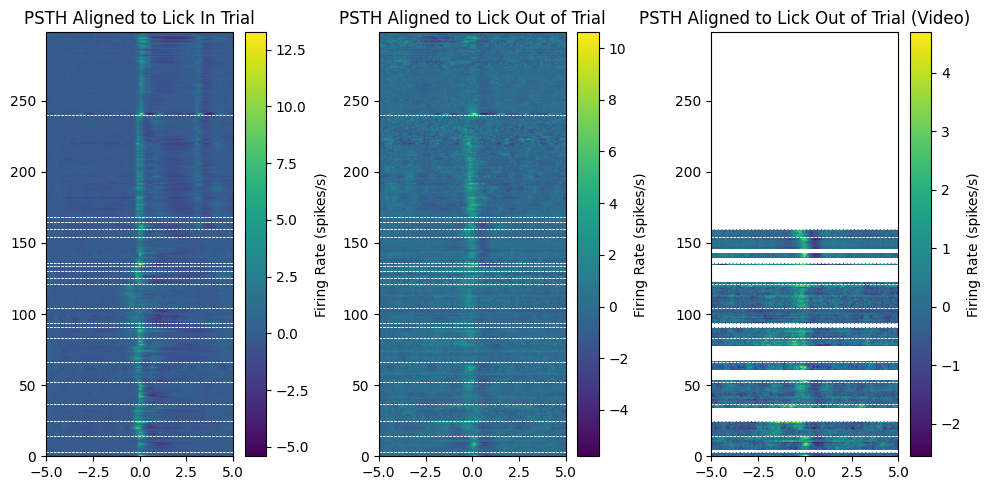

In [127]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
psth_in_trial = np.array(psth_in_trial)
psth_out_trial = np.array(psth_out_trial)
bin_size = 0.2
step_size = 0.05
tb = -5
tf = 5
#
im1 = ax[0].imshow(psth_in_trial, aspect='auto', extent=[tb, tf, 0, psth_in_trial.shape[0]], origin='lower')
ax[0].set_title('PSTH Aligned to Lick In Trial')
# draw vertical line between each animal
ani_ind_list = results_df['ani_id'].values
for ani_id in np.unique(ani_ind_list):
    ani_inds = np.where(ani_ind_list == ani_id)[0]
    ax[0].axhline(ani_inds[0], color='w', linestyle='--', linewidth=0.5)
    ax[0].axhline(ani_inds[-1]+1, color='w', linestyle='--', linewidth=0.5)

im2 = ax[1].imshow(psth_out_trial, aspect='auto', extent=[tb, tf, 0, psth_out_trial.shape[0]], origin='lower')
ax[1].set_title('PSTH Aligned to Lick Out of Trial')
for ani_id in np.unique(ani_ind_list):
    ani_inds = np.where(ani_ind_list == ani_id)[0]
    ax[1].axhline(ani_inds[0], color='w', linestyle='--', linewidth=0.5)
    ax[1].axhline(ani_inds[-1]+1, color='w', linestyle='--', linewidth=0.5)

im3 = ax[2].imshow(psth_out_trial_video, aspect='auto', extent=[tb, tf, 0, psth_out_trial_video.shape[0]], origin='lower')
ax[2].set_title('PSTH Aligned to Lick Out of Trial (Video)')
for ani_id in np.unique(ani_ind_list):
    ani_inds = np.where(ani_ind_list == ani_id)[0]
    ax[2].axhline(ani_inds[0], color='w', linestyle='--', linewidth=0.5)
    ax[2].axhline(ani_inds[-1]+1, color='w', linestyle='--', linewidth=0.5)
fig.colorbar(im1, ax=ax[0], label='Firing Rate (spikes/s)')
fig.colorbar(im2, ax=ax[1], label='Firing Rate (spikes/s)')
fig.colorbar(im3, ax=ax[2], label='Firing Rate (spikes/s)')

plt.tight_layout()

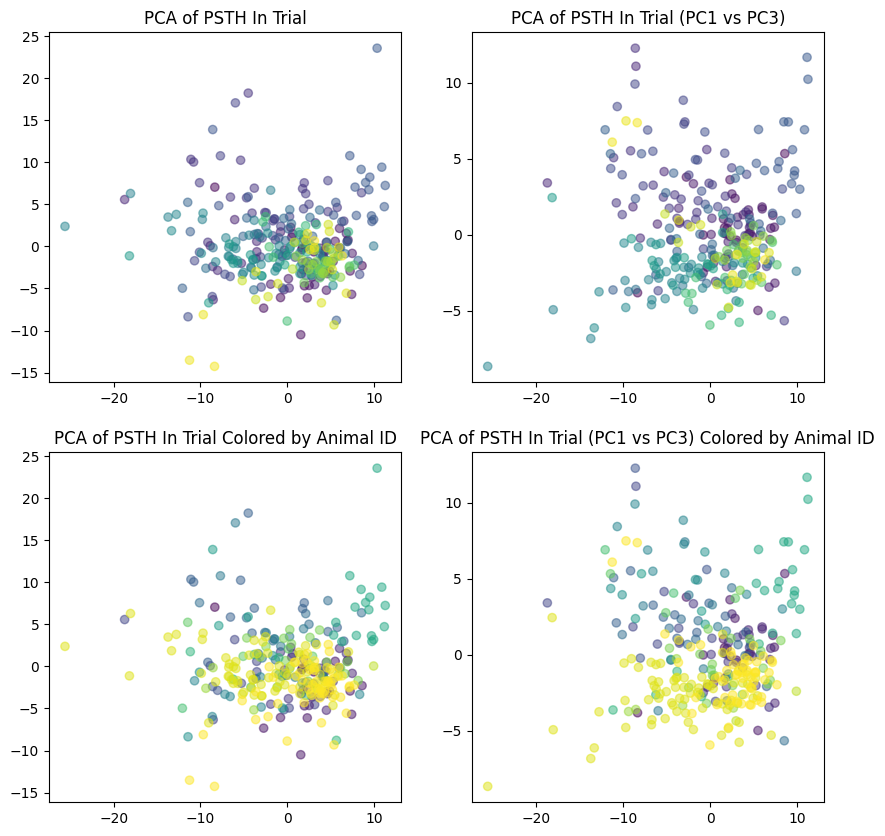

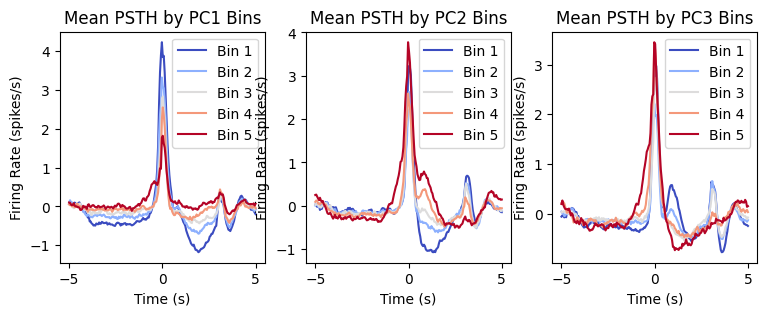

In [128]:
# pca on psth 
from sklearn.decomposition import PCA
# zscore psth
from scipy.stats import zscore
pca_in = PCA(n_components=3)
pca_result_in = pca_in.fit_transform(zscore(psth_in_trial[:, :-50], axis=0))
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(pca_result_in[:, 0], pca_result_in[:, 1], alpha=0.5, c=results_df['session'].astype('category').cat.codes)
ax[0, 0].set_title('PCA of PSTH In Trial')
ax[0, 1].scatter(pca_result_in[:, 0], pca_result_in[:, 2], alpha=0.5, c=results_df['session'].astype('category').cat.codes)
ax[0, 1].set_title('PCA of PSTH In Trial (PC1 vs PC3)')
 
ax[1, 0].scatter(pca_result_in[:, 0], pca_result_in[:, 1], alpha=0.5, c=results_df['ani_id'].astype('category').cat.codes)
ax[1, 0].set_title('PCA of PSTH In Trial Colored by Animal ID')
ax[1, 1].scatter(pca_result_in[:, 0], pca_result_in[:, 2], alpha=0.5, c=results_df['ani_id'].astype('category').cat.codes)
ax[1, 1].set_title('PCA of PSTH In Trial (PC1 vs PC3) Colored by Animal ID')
plt.show()


# bin psth by PCs
pc_bins = 5
plot_pcs = 3
fig, axes = plt.subplots(1, plot_pcs, figsize=(3*plot_pcs, 3))
color_code = plt.cm.coolwarm(np.linspace(0, 1, pc_bins))
for pc_ind in range(plot_pcs):
    pc_values = pca_result_in[:, pc_ind]
    bin_edges = np.percentile(pc_values, np.linspace(0, 100, pc_bins+1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean_psth_per_bin = []
    for i in range(pc_bins):
        bin_mask = (pc_values >= bin_edges[i]) & (pc_values < bin_edges[i+1])
        mean_psth = np.nanmean(psth_in_trial[bin_mask], axis=0)
        mean_psth_per_bin.append(mean_psth)
    mean_psth_per_bin = np.array(mean_psth_per_bin)
    for i in range(pc_bins):
        axes[pc_ind].plot(np.linspace(tb, tf, mean_psth_per_bin.shape[1]), mean_psth_per_bin[i], label=f'Bin {i+1}', color=color_code[i])
    axes[pc_ind].set_title(f'Mean PSTH by PC{pc_ind+1} Bins')
    axes[pc_ind].set_xlabel('Time (s)')
    axes[pc_ind].set_ylabel('Firing Rate (spikes/s)')
    axes[pc_ind].legend()



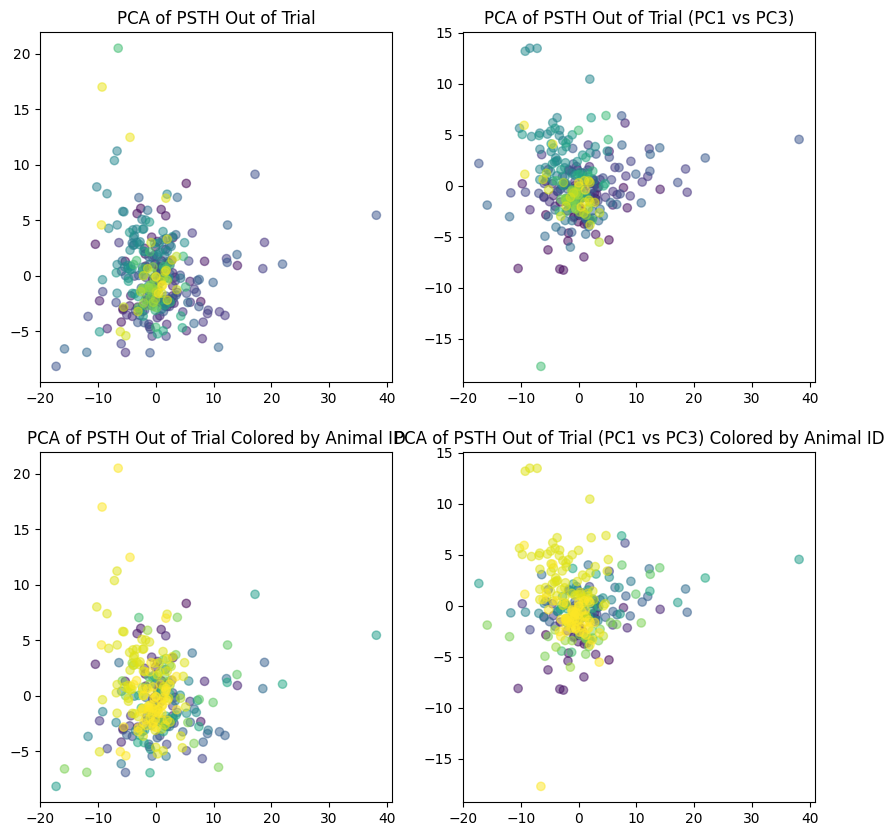

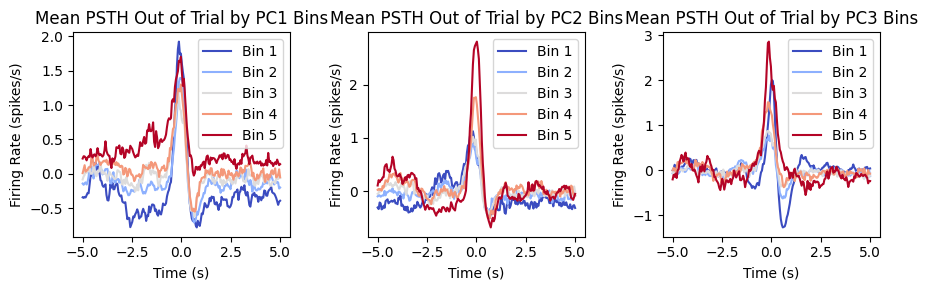

In [129]:
# do the same for out of trial with behavior_licks, remove nan rows
valid_out_mask = ~np.isnan(psth_out_trial).any(axis=1)
pca_out = PCA(n_components=3)
pca_result_out = pca_out.fit_transform(zscore(psth_out_trial[valid_out_mask, :-50]))
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(pca_result_out[:, 0], pca_result_out[:, 1], alpha=0.5, c=results_df.loc[valid_out_mask, 'session'].astype('category').cat.codes)
ax[0, 0].set_title('PCA of PSTH Out of Trial')
ax[0, 1].scatter(pca_result_out[:, 0], pca_result_out[:, 2], alpha=0.5, c=results_df.loc[valid_out_mask, 'session'].astype('category').cat.codes)
ax[0, 1].set_title('PCA of PSTH Out of Trial (PC1 vs PC3)')
ax[1, 0].scatter(pca_result_out[:, 0], pca_result_out[:, 1], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
ax[1, 0].set_title('PCA of PSTH Out of Trial Colored by Animal ID')
ax[1, 1].scatter(pca_result_out[:, 0], pca_result_out[:, 2], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
ax[1, 1].set_title('PCA of PSTH Out of Trial (PC1 vs PC3) Colored by Animal ID')
plt.show()
# bin psth by PCs
pc_bins = 5
plot_pcs = 3
fig, axes = plt.subplots(1, plot_pcs, figsize=(3*plot_pcs, 3))
color_code = plt.cm.coolwarm(np.linspace(0, 1, pc_bins))
for pc_ind in range(plot_pcs):
    pc_values = pca_result_out[:, pc_ind]
    bin_edges = np.percentile(pc_values, np.linspace(0, 100, pc_bins+1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean_psth_per_bin = []
    for i in range(pc_bins):
        bin_mask = (pc_values >= bin_edges[i]) & (pc_values < bin_edges[i+1])
        mean_psth = np.nanmean(psth_out_trial[valid_out_mask][bin_mask], axis=0)
        mean_psth_per_bin.append(mean_psth)
    mean_psth_per_bin = np.array(mean_psth_per_bin)
    for i in range(pc_bins):
        axes[pc_ind].plot(np.linspace(tb, tf, mean_psth_per_bin.shape[1]), mean_psth_per_bin[i], label=f'Bin {i+1}', color=color_code[i])
    axes[pc_ind].set_title(f'Mean PSTH Out of Trial by PC{pc_ind+1} Bins')
    axes[pc_ind].set_xlabel('Time (s)')
    axes[pc_ind].set_ylabel('Firing Rate (spikes/s)')
    axes[pc_ind].legend()
plt.tight_layout()

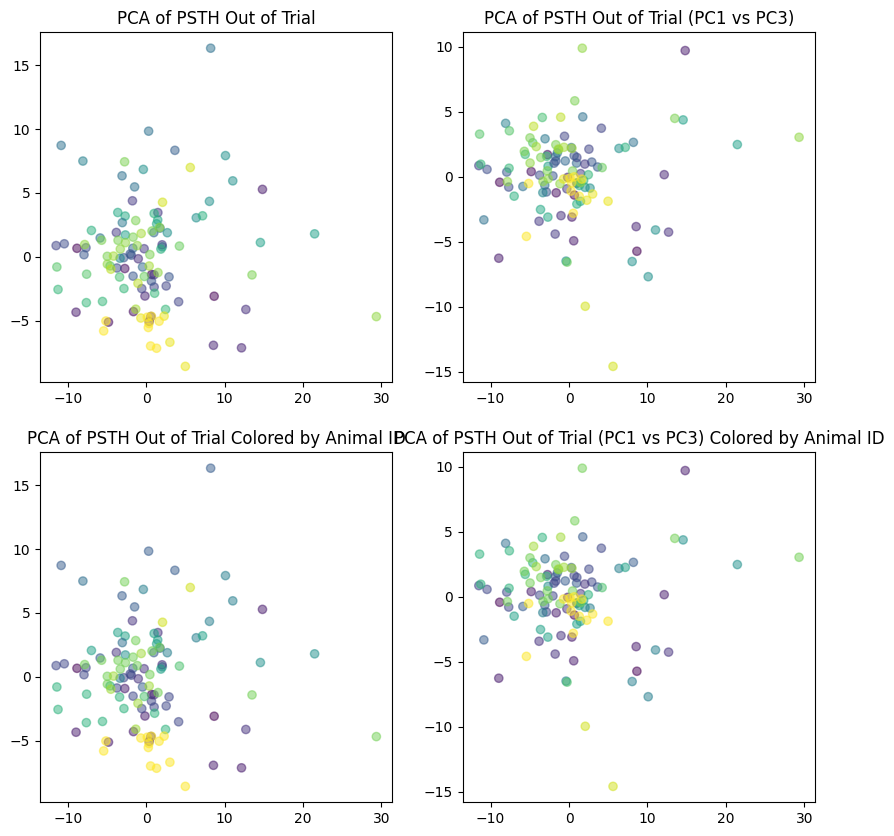

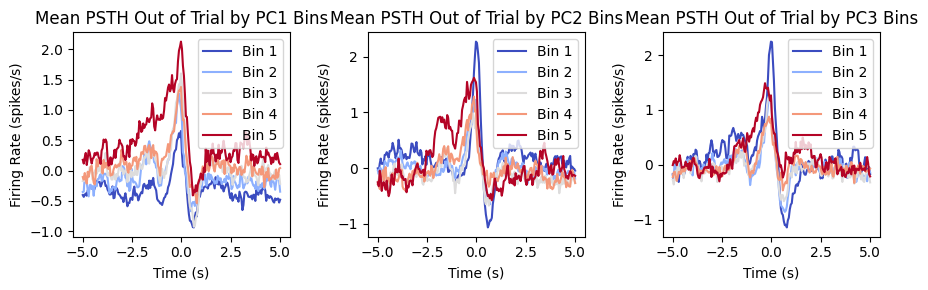

In [130]:
# do the same for out of trial with behavior_licks, remove nan rows
valid_out_mask = ~np.isnan(psth_out_trial_video).any(axis=1)
pca_out = PCA(n_components=3)
pca_result_out_video = pca_out.fit_transform(zscore(psth_out_trial_video[valid_out_mask, :-50]))
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].scatter(pca_result_out_video[:, 0], pca_result_out_video[:, 1], alpha=0.5, c=results_df.loc[valid_out_mask, 'session'].astype('category').cat.codes)
ax[0, 0].set_title('PCA of PSTH Out of Trial')
ax[0, 1].scatter(pca_result_out_video[:, 0], pca_result_out_video[:, 2], alpha=0.5, c=results_df.loc[valid_out_mask, 'session'].astype('category').cat.codes)
ax[0, 1].set_title('PCA of PSTH Out of Trial (PC1 vs PC3)')
ax[1, 0].scatter(pca_result_out_video[:, 0], pca_result_out_video[:, 1], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
ax[1, 0].set_title('PCA of PSTH Out of Trial Colored by Animal ID')
ax[1, 1].scatter(pca_result_out_video[:, 0], pca_result_out_video[:, 2], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
ax[1, 1].set_title('PCA of PSTH Out of Trial (PC1 vs PC3) Colored by Animal ID')
plt.show()
# bin psth by PCs
pc_bins = 5
plot_pcs = 3
fig, axes = plt.subplots(1, plot_pcs, figsize=(3*plot_pcs, 3))
color_code = plt.cm.coolwarm(np.linspace(0, 1, pc_bins))
for pc_ind in range(plot_pcs):
    pc_values = pca_result_out_video[:, pc_ind]
    bin_edges = np.percentile(pc_values, np.linspace(0, 100, pc_bins+1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean_psth_per_bin = []
    for i in range(pc_bins):
        bin_mask = (pc_values >= bin_edges[i]) & (pc_values < bin_edges[i+1])
        mean_psth = np.nanmean(psth_out_trial_video[valid_out_mask][bin_mask], axis=0)
        mean_psth_per_bin.append(mean_psth)
    mean_psth_per_bin = np.array(mean_psth_per_bin)
    for i in range(pc_bins):
        axes[pc_ind].plot(np.linspace(tb, tf, mean_psth_per_bin.shape[1]), mean_psth_per_bin[i], label=f'Bin {i+1}', color=color_code[i])
    axes[pc_ind].set_title(f'Mean PSTH Out of Trial by PC{pc_ind+1} Bins')
    axes[pc_ind].set_xlabel('Time (s)')
    axes[pc_ind].set_ylabel('Firing Rate (spikes/s)')
    axes[pc_ind].legend()
plt.tight_layout()

In [131]:
# # correlation between in trial and out of trial psth pc scores
# common_units_mask = valid_out_mask
# fig, ax = plt.subplots(3, 3, figsize=(15, 15))
# for pc_ind_in in range(3):
#     for pc_ind_out in range(3):
#         ax[pc_ind_in, pc_ind_out].scatter(pca_result_in[common_units_mask, pc_ind_in], pca_result_out[:, pc_ind_out], alpha=0.5)
#         ax[pc_ind_in, pc_ind_out].set_xlabel(f'PC{pc_ind_in+1} In Trial')
#         ax[pc_ind_in, pc_ind_out].set_ylabel(f'PC{pc_ind_out+1} Out of Trial')
#         r, p = pearsonr(pca_result_in[common_units_mask, pc_ind_in], pca_result_out[:, pc_ind_out])
#         ax[pc_ind_in, pc_ind_out].set_title(f'r={r:.2f}, p={p:.3f}')


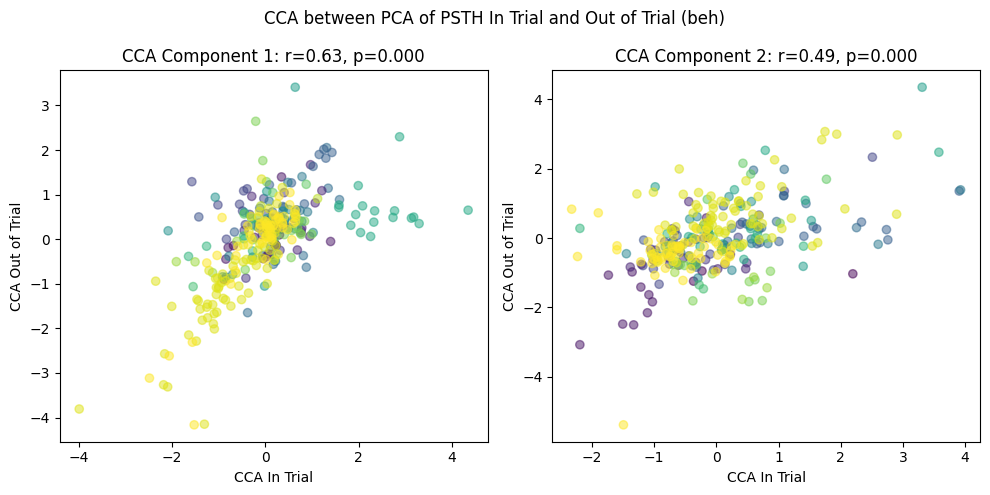

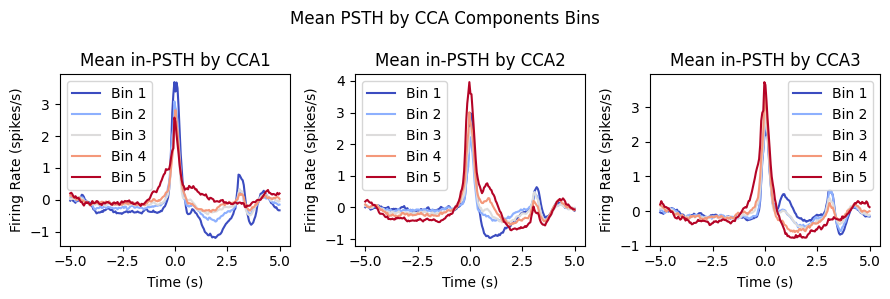

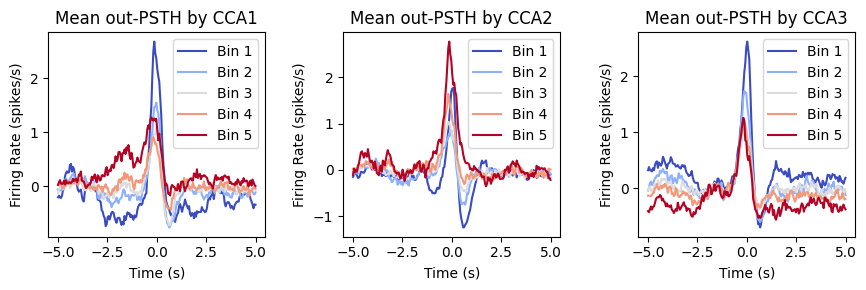

In [132]:
# perform cca over pca in trial and out of trial to find the best correlation features 
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=3)
valid_out_mask = ~np.isnan(psth_out_trial).any(axis=1)
cca_result_in, cca_result_out = cca.fit_transform(pca_result_in[valid_out_mask, :], pca_result_out)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# scatter and color code by animal id
ax[0].scatter(cca_result_in[:, 0], cca_result_out[:, 0], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
# print correlation
r, p = pearsonr(cca_result_in[:, 0], cca_result_out[:, 0])
ax[0].set_title(f'CCA Component 1: r={r:.2f}, p={p:.3f}')
ax[0].set_xlabel('CCA In Trial')
ax[0].set_ylabel('CCA Out of Trial')
ax[1].scatter(cca_result_in[:, 1], cca_result_out[:, 1], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
r, p = pearsonr(cca_result_in[:, 1], cca_result_out[:, 1])
ax[1].set_title(f'CCA Component 2: r={r:.2f}, p={p:.3f}')
ax[1].set_xlabel('CCA In Trial')
ax[1].set_ylabel('CCA Out of Trial')
plt.suptitle('CCA between PCA of PSTH In Trial and Out of Trial (beh)')
plt.tight_layout()


# plot mean psth by cca components
# for in trial psth
pc_bins = 5
plot_ccas = 3
fig, axes = plt.subplots(1, plot_ccas, figsize=(3*plot_ccas, 3))
color_code = plt.cm.coolwarm(np.linspace(0, 1, pc_bins))
for cca_ind in range(plot_ccas):
    cca_values = cca_result_in[:, cca_ind]
    bin_edges = np.percentile(cca_values, np.linspace(0, 100, pc_bins+1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean_psth_per_bin = []
    for i in range(pc_bins):
        bin_mask = (cca_values >= bin_edges[i]) & (cca_values < bin_edges[i+1])
        mean_psth = np.nanmean(psth_in_trial[valid_out_mask][bin_mask], axis=0)
        mean_psth_per_bin.append(mean_psth)
    mean_psth_per_bin = np.array(mean_psth_per_bin)
    for i in range(pc_bins):
        axes[cca_ind].plot(np.linspace(tb, tf, mean_psth_per_bin.shape[1]), mean_psth_per_bin[i], label=f'Bin {i+1}', color=color_code[i])
    axes[cca_ind].set_title(f'Mean in-PSTH by CCA{cca_ind+1}')
    axes[cca_ind].set_xlabel('Time (s)')
    axes[cca_ind].set_ylabel('Firing Rate (spikes/s)')
    axes[cca_ind].legend()
plt.suptitle('Mean PSTH by CCA Components Bins')
plt.tight_layout()
# for out of trial psth
pc_bins = 5
plot_ccas = 3
fig, axes = plt.subplots(1, plot_ccas, figsize=(3*plot_ccas, 3))
color_code = plt.cm.coolwarm(np.linspace(0, 1, pc_bins))

for cca_ind in range(plot_ccas):
    cca_values = cca_result_out[:, cca_ind]
    bin_edges = np.percentile(cca_values, np.linspace(0, 100, pc_bins+1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean_psth_per_bin = []
    for i in range(pc_bins):
        bin_mask = (cca_values >= bin_edges[i]) & (cca_values < bin_edges[i+1])
        mean_psth = np.nanmean(psth_out_trial[valid_out_mask][bin_mask], axis=0)
        mean_psth_per_bin.append(mean_psth)
    mean_psth_per_bin = np.array(mean_psth_per_bin)
    for i in range(pc_bins):
        axes[cca_ind].plot(np.linspace(tb, tf, mean_psth_per_bin.shape[1]), mean_psth_per_bin[i], label=f'Bin {i+1}', color=color_code[i])
    axes[cca_ind].set_title(f'Mean out-PSTH by CCA{cca_ind+1}')
    axes[cca_ind].set_xlabel('Time (s)')
    axes[cca_ind].set_ylabel('Firing Rate (spikes/s)')
    axes[cca_ind].legend()
plt.tight_layout()

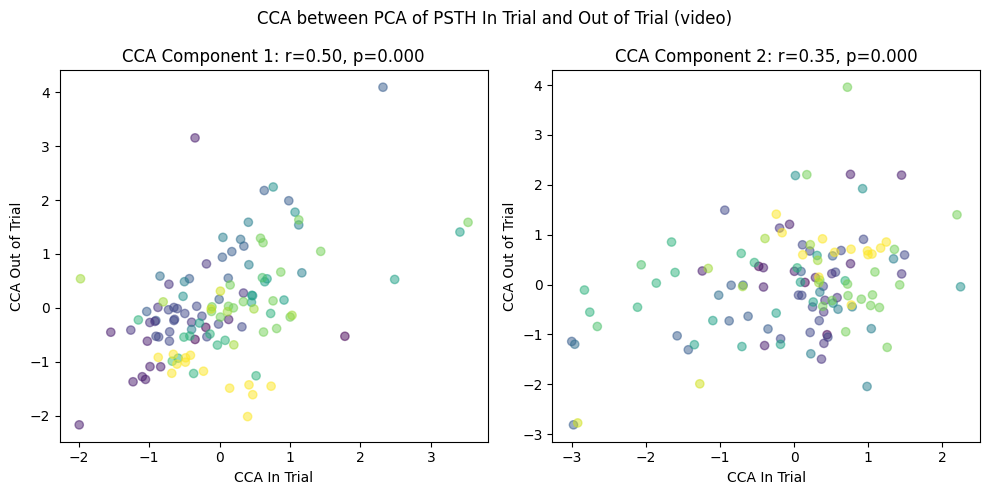

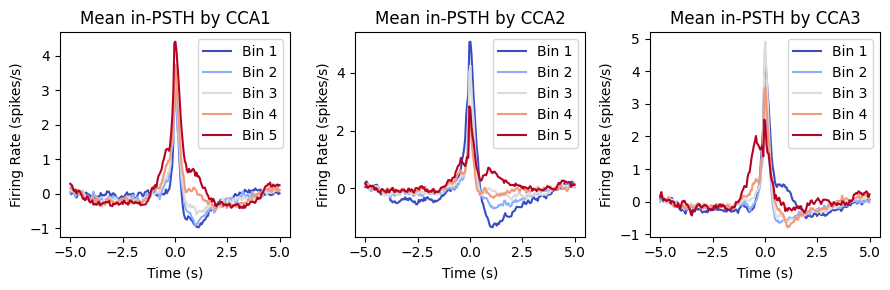

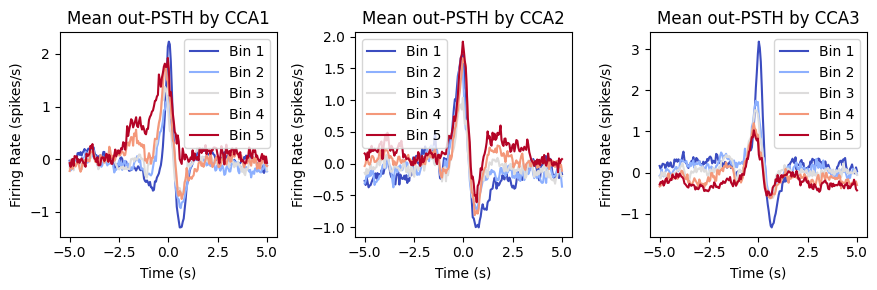

In [133]:
# perform cca over pca in trial and out of trial to find the best correlation features 
from sklearn.cross_decomposition import CCA
cca_video = CCA(n_components=3)
valid_out_mask = ~np.isnan(psth_out_trial_video).any(axis=1)
cca_result_in, cca_result_out = cca_video.fit_transform(pca_result_in[valid_out_mask, :], pca_result_out_video)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# scatter and color code by animal id
ax[0].scatter(cca_result_in[:, 0], cca_result_out[:, 0], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
# print correlation
r, p = pearsonr(cca_result_in[:, 0], cca_result_out[:, 0])
ax[0].set_title(f'CCA Component 1: r={r:.2f}, p={p:.3f}')
ax[0].set_xlabel('CCA In Trial')
ax[0].set_ylabel('CCA Out of Trial')
ax[1].scatter(cca_result_in[:, 1], cca_result_out[:, 1], alpha=0.5, c=results_df.loc[valid_out_mask, 'ani_id'].astype('category').cat.codes)
r, p = pearsonr(cca_result_in[:, 1], cca_result_out[:, 1])
ax[1].set_title(f'CCA Component 2: r={r:.2f}, p={p:.3f}')
ax[1].set_xlabel('CCA In Trial')
ax[1].set_ylabel('CCA Out of Trial')
plt.suptitle('CCA between PCA of PSTH In Trial and Out of Trial (video)')
plt.tight_layout()

# plot mean psth by cca components
# for in trial psth
pc_bins = 5
plot_ccas = 3
fig, axes = plt.subplots(1, plot_ccas, figsize=(3*plot_ccas, 3))
color_code = plt.cm.coolwarm(np.linspace(0, 1, pc_bins))
for cca_ind in range(plot_ccas):
    cca_values = cca_result_in[:, cca_ind]
    bin_edges = np.percentile(cca_values, np.linspace(0, 100, pc_bins+1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean_psth_per_bin = []
    for i in range(pc_bins):
        bin_mask = (cca_values >= bin_edges[i]) & (cca_values < bin_edges[i+1])
        mean_psth = np.nanmean(psth_in_trial[valid_out_mask][bin_mask], axis=0)
        mean_psth_per_bin.append(mean_psth)
    mean_psth_per_bin = np.array(mean_psth_per_bin)
    for i in range(pc_bins):
        axes[cca_ind].plot(np.linspace(tb, tf, mean_psth_per_bin.shape[1]), mean_psth_per_bin[i], label=f'Bin {i+1}', color=color_code[i])
    axes[cca_ind].set_title(f'Mean in-PSTH by CCA{cca_ind+1}')
    axes[cca_ind].set_xlabel('Time (s)')
    axes[cca_ind].set_ylabel('Firing Rate (spikes/s)')
    axes[cca_ind].legend()
plt.tight_layout()
# for out of trial psth
pc_bins = 5
plot_ccas = 3
fig, axes = plt.subplots(1, plot_ccas, figsize=(3*plot_ccas, 3))
color_code = plt.cm.coolwarm(np.linspace(0, 1, pc_bins))

for cca_ind in range(plot_ccas):
    cca_values = cca_result_out[:, cca_ind]
    bin_edges = np.percentile(cca_values, np.linspace(0, 100, pc_bins+1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean_psth_per_bin = []
    for i in range(pc_bins):
        bin_mask = (cca_values >= bin_edges[i]) & (cca_values < bin_edges[i+1])
        mean_psth = np.nanmean(psth_out_trial[valid_out_mask][bin_mask], axis=0)
        mean_psth_per_bin.append(mean_psth)
    mean_psth_per_bin = np.array(mean_psth_per_bin)
    for i in range(pc_bins):
        axes[cca_ind].plot(np.linspace(tb, tf, mean_psth_per_bin.shape[1]), mean_psth_per_bin[i], label=f'Bin {i+1}', color=color_code[i])
    axes[cca_ind].set_title(f'Mean out-PSTH by CCA{cca_ind+1}')
    axes[cca_ind].set_xlabel('Time (s)')
    axes[cca_ind].set_ylabel('Firing Rate (spikes/s)')
    axes[cca_ind].legend()
plt.tight_layout()

In [134]:
cca_weights_on_psth_in = np.dot(cca.x_weights_, pca_in.components_)
cca_weights_on_psth_out = np.dot(cca.y_weights_, pca_out.components_)

In [135]:
cca_weights_on_psth_in_video = np.dot(cca_video.y_weights_, pca_out.components_)
cca_weights_on_psth_out_video = np.dot(cca_video.y_weights_, pca_out.components_)

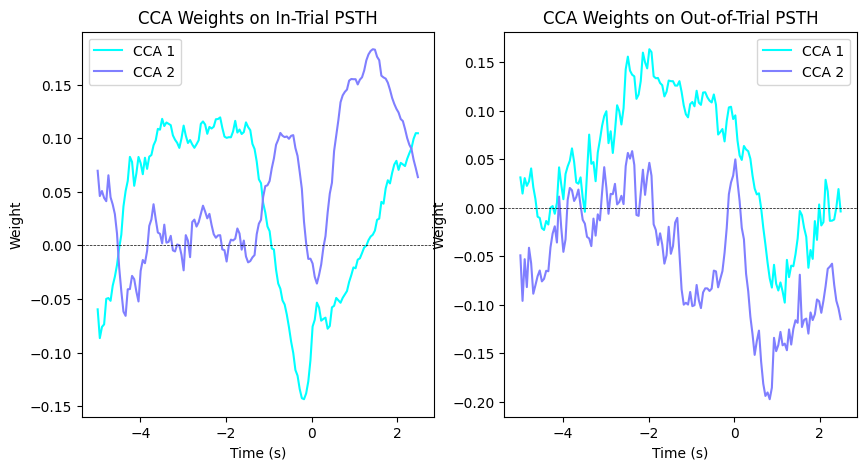

In [136]:
# plot weights
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
color_code = plt.cm.cool(np.linspace(0, 1, 3))
for i in range(2):
    ax[0].plot(np.linspace(tb, tf, psth_in_trial.shape[1])[:-50], cca_weights_on_psth_in[i, :], label=f'CCA {i+1}', color=color_code[i])
ax[0].set_title('CCA Weights on In-Trial PSTH')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Weight')
ax[0].legend()
ax[0].axhline(0, color='k', linestyle='--', linewidth=0.5)
for i in range(2):
    ax[1].plot(np.linspace(tb, tf, psth_in_trial.shape[1])[:-50], cca_weights_on_psth_out[i, :], label=f'CCA {i+1}', color=color_code[i])
ax[1].set_title('CCA Weights on Out-of-Trial PSTH')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Weight')
ax[1].legend()
ax[1].axhline(0, color='k', linestyle='--', linewidth=0.5)

In [137]:
# cal peak and peak lat for psth_in and psth_out
def cal_peak_latency(psth, time_vector, search_window, base_window):
    peak_vals = []
    peak_lats = []
    rise_vals = []
    for i in range(psth.shape[0]):
        window_mask = (time_vector >= search_window[0]) & (time_vector <= search_window[1])
        base_mask = (time_vector >= base_window[0]) & (time_vector <= base_window[1])
        psth_window = psth[i, window_mask]
        time_window = time_vector[window_mask]
        time_base = time_vector[base_mask]
        if len(psth_window) == 0:
            peak_vals.append(np.nan)
            peak_lats.append(np.nan)
            rise_vals.append(np.nan)
            continue
        peak_val = np.max(psth_window)
        peak_lat = time_window[np.argmax(psth_window)]
        baseline = np.mean(psth[i, base_mask])
        peak_vals.append(peak_val)
        peak_lats.append(peak_lat)
        rise_vals.append(peak_val - baseline)
    return np.array(peak_vals), np.array(peak_lats), np.array(rise_vals)
time_vector = np.linspace(tb, tf, psth_in_trial.shape[1])
search_window = (-1, 0.5)
base_window = (-2, -1)
peak_vals_in, peak_lats_in, rise_in = cal_peak_latency(psth_in_trial, time_vector, search_window, base_window)
peak_vals_out, peak_lats_out, rise_out = cal_peak_latency(psth_out_trial, time_vector, search_window, base_window)
peak_vals_out_video, peak_lats_out_video, rise_out_video = cal_peak_latency(psth_out_trial_video, time_vector, search_window, base_window)  
# add to results df
results_df['peak_val_in'] = peak_vals_in
results_df['peak_lat_in'] = peak_lats_in
results_df['peak_val_out_video'] = peak_vals_out_video
results_df['peak_val_out'] = peak_vals_out
results_df['peak_lat_out'] = peak_lats_out
results_df['peak_lat_out_video'] = peak_lats_out_video
results_df['rise_in'] = rise_in
results_df['rise_out'] = rise_out
results_df['rise_out_video'] = rise_out_video
results_df['peak_in-out_diff'] = (results_df['peak_val_in'] - results_df['peak_val_out'])
results_df['lat_in-out_diff'] = results_df['peak_lat_in'] - results_df['peak_lat_out']


In [154]:
# append cca and pca scores to results df
# pca_out
pca_out_full = np.full((psth_in_trial.shape[0], 3), np.nan)
valid_out_mask = ~np.isnan(psth_out_trial).any(axis=1)
pca_out_full[valid_out_mask, :] = pca_result_out
pca_out_full_video = np.full((psth_in_trial.shape[0], 3), np.nan)
valid_out_mask = ~np.isnan(psth_out_trial_video).any(axis=1)
pca_out_full_video[valid_out_mask, :] = pca_result_out_video
results_df['pca_in_1'] = pca_result_in[:, 0]
results_df['pca_in_2'] = pca_result_in[:, 1]
results_df['pca_in_3'] = pca_result_in[:, 2]    
results_df['pca_out_1'] = pca_out_full[:, 0]
results_df['pca_out_2'] = pca_out_full[:, 1]
results_df['pca_out_3'] = pca_out_full[:, 2]
results_df['pca_out_video_1'] = pca_out_full_video[:, 0]
results_df['pca_out_video_2'] = pca_out_full_video[:, 1]
results_df['pca_out_video_3'] = pca_out_full_video[:, 2]
results_df['cca_in_1'] = np.full(psth_in_trial.shape[0], np.nan)
results_df['cca_in_2'] = np.full(psth_in_trial.shape[0], np.nan)
results_df['cca_out_1'] = np.full(psth_in_trial.shape[0], np.nan)
results_df['cca_out_2'] = np.full(psth_in_trial.shape[0], np.nan)
valid_out_mask = ~np.isnan(psth_out_trial).any(axis=1)
cca_result_in, cca_result_out = cca.fit_transform(pca_result_in[valid_out_mask, :], pca_result_out)
results_df.loc[valid_out_mask, 'cca_in_1'] = cca_result_in[:, 0]
results_df.loc[valid_out_mask, 'cca_in_2'] = cca_result_in[:, 1]
results_df.loc[valid_out_mask, 'cca_out_1'] = cca_result_out[:, 0]
results_df.loc[valid_out_mask, 'cca_out_2'] = cca_result_out[:, 1]


In [139]:
# results_df = results_df.merge(combined_tagged_units_filtered, on=['session', 'unit_id'], how='left')
# append behavior model results and basic ephys results
results_df = results_df.merge(model_df, on=['session', 'unit_id'], how='left')
results_df = results_df.merge(basic_ephys_df, on=['session', 'unit_id'], how='left')
results_df = results_df.merge(response_tbl, on=['session', 'unit_id'], how='left')
results_df = results_df.merge(combined_tagged_units_filtered[['session', 'unit_id', 'x_ccf', 'y_ccf', 'z_ccf']], on=['session', 'unit_id'], how='left')

In [140]:
# plot in ccf space
from utils.ccf_utils import project_to_plane, pir_to_lps
from trimesh import load_mesh
import k3d

ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
# mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)



mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

In [141]:
features_to_plot = ['pca_in_1', 'pca_in_2', 'pca_out_1', 'pca_out_2', 'cca_in_1', 'cca_out_1', 'pca_out_video_1', 'pca_out_video_2',
                    'peak_val_in', 'peak_val_out', 'peak_val_out_video',
                    'peak_lat_in', 'peak_lat_out', 'peak_lat_out_video', 
                    'peak_in-out_diff', 'lat_in-out_diff', 'rise_in', 'rise_out', 'rise_out_video']

In [155]:
spatial_dependence_results = {}
# --- 3D anatomical points ---
ccfs = results_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
mask = ~np.isnan(ccfs).any(axis=1)  # mask for valid ccf points
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere
for feature in features_to_plot:
    values = results_df[feature].values.astype(float)
    result = spatial_dependence_summary(
        ccfs[mask, :],
        values[mask],
        k_neighbors=30,
        n_splits=5,
        permutations=2000,
        seed=42,
    )
    spatial_dependence_results[feature] = result


In [156]:
# # multiple comparison correction (FDR)
# from statsmodels.stats.multitest import multipletests
# # for knn
# p_values = [spatial_dependence_results[feat]['cv_predictability_knn']['p_value_permutation'] for feat in results_df.columns if feat in spatial_dependence_results.keys()]
# reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# for i, feature_name in spatial_dependence_results.keys():
#     spatial_dependence_results[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
#     spatial_dependence_results[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# # for trend
# p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_permutation_r2'] for feat in feature_map.keys()]
# reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
# for i, feature_name in spatial_dependence_results.keys():
#     spatial_dependence_results[feature_name]['linear_trend']['p_value_permutation_r2_fdr'] = pvals_corrected[i]
#     spatial_dependence_results[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results
output_file = os.path.join(target_folder, f'spatial_dependence_results_{criteria_name}.pkl')
with open(output_file, 'wb') as f:
    pickle.dump(spatial_dependence_results, f)

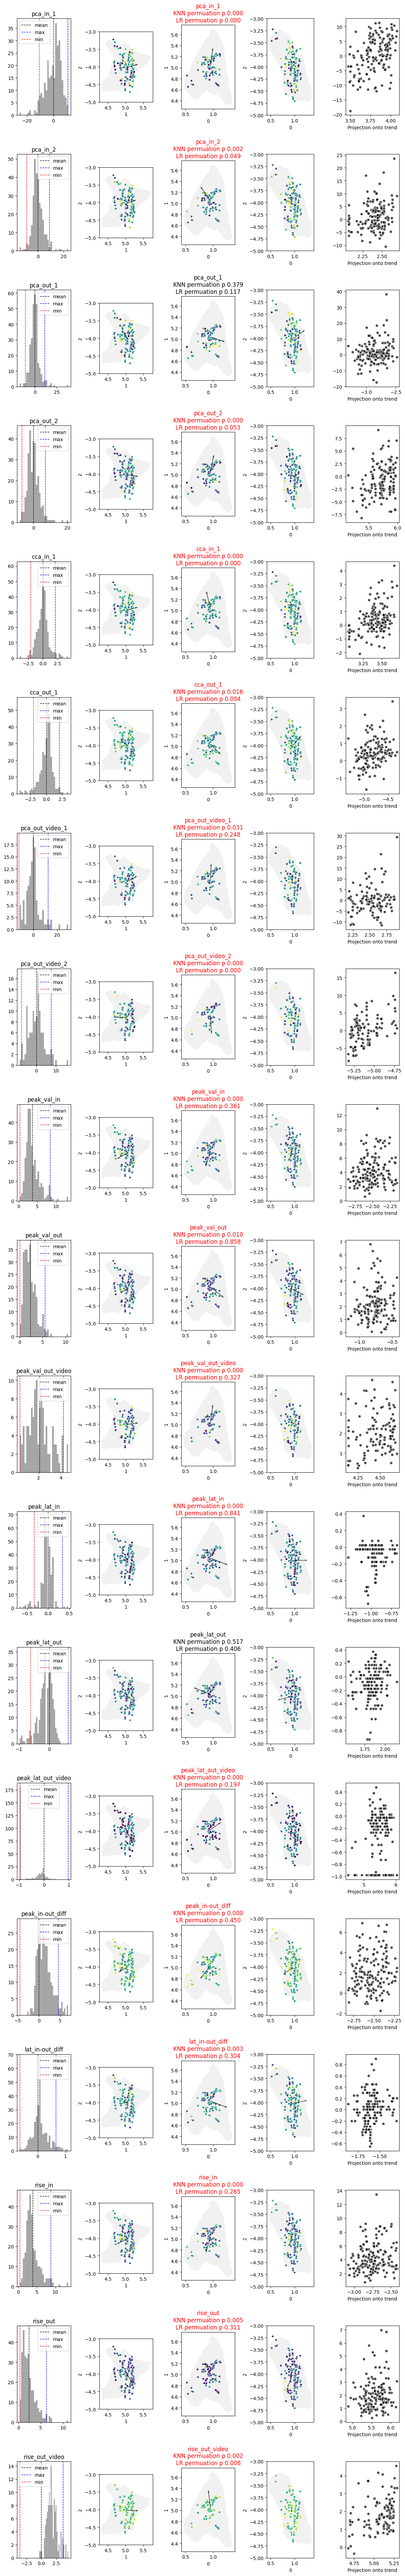

In [157]:
fig, axes = plt.subplots(len(features_to_plot), 5, figsize=(12, 4 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- 3D anatomical points ---
ccfs = results_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere
mask = np.ones(shape=ccfs.shape[0], dtype=bool)
for ind, feature in enumerate(features_to_plot):
    color = results_df[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.95)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        # color_reg[~np.isnan(color_reg)] = rankdata(color_reg[~np.isnan(color_reg)]) / len(color_reg[~np.isnan(color_reg)])
        # === Colormap ===
        custom_cmap = cm.get_cmap('viridis')
        # custom_cmap = LinearSegmentedColormap.from_list('white_red', [(0.0, 'white'), (1.0, 'black')])

    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg))/(amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        # === Colormap === viridis
        custom_cmap = cm.get_cmap('viridis')

    # color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(results_df[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()
   # prevent extremes

    # === Sort and filter ===
    # sorted df
    sort_ind = np.argsort(color_reg[mask])[::-1]
    features_combined_sorted = results_df[mask].iloc[sort_ind]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]


    # === Precompute RGBA facecolors ===
    rgba_colors = custom_cmap(color_reg_plot)
    # rgba_colors[:, -1] = alpha_scale_plot  # inject alpha per point
    rgba_colors[:, -1] = 1  # fixed alpha

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        # ax.scatter(
        #     mesh_vertices_mm[:, planes[plane][0]],
        #     mesh_vertices_mm[:, planes[plane][1]],
        #     color='k', alpha=0.4, s=0.05, edgecolors='none'
        # )
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)

        # scatter the points (alpha-scaled)
        # only plot those not NaN
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]][~np.isnan(color_reg_plot)],
            ccfs_plot[:, planes[plane][1]][~np.isnan(color_reg_plot)],
            facecolors=rgba_colors[~np.isnan(color_reg_plot)],
            edgecolors=[1, 1, 1],
            s=20,
            linewidths=0.5,
        )
        # add linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']<0.05 or spatial_dependence_results[feature]['linear_trend']['p_value_permutation_r2']<0.05:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"KNN permuation p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation']:.3f}\n"
                f"LR permuation p {spatial_dependence_results[feature]['linear_trend']['p_value_permutation_r2']:.3f}",
                color=title_color
            )

        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])

    ax_scatter = axes[ind, -1]
    ccf_proj = ccfs @ arrow_vec
    ax_scatter.scatter(ccf_proj, color, alpha=0.7, edgecolors='white', color = 'k')
    ax_scatter.set_xlabel('Projection onto trend')

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(target_folder, f'lick_psth_combined_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300) 
# plt.close()


In [145]:
# save _results_df as pkl
output_file = os.path.join(target_folder, f'lick_psth_combined_results_{criteria_name}.pkl')
with open(output_file, 'wb') as f:
    pickle.dump(results_df, f)

In [146]:
# load results_df
output_file = os.path.join(target_folder, f'lick_psth_combined_results_{criteria_name}.pkl')
with open(output_file, 'rb') as f:
    results_df = pickle.load(f)

<Figure size 1000x1000 with 0 Axes>

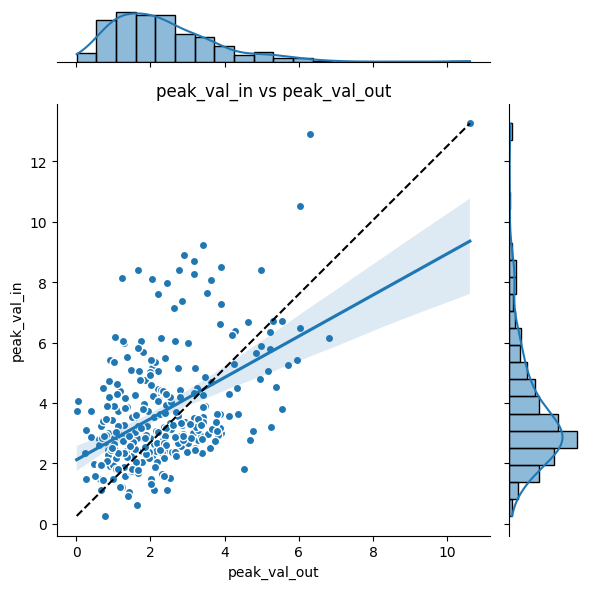

In [163]:
fig = plt.figure(figsize=(10, 10))
# diagonal line
x = 'peak_val_out'
y = 'peak_val_in'
g = sns.jointplot(x=x, y=y, data=results_df, kind='reg', scatter_kws={'alpha':1, 'edgecolors':'w'})
# add diagonal line
g.ax_joint.plot([results_df[x].min(), results_df[x].max()], [results_df[y].min(), results_df[y].max()], 'k--')
# plt.plot([results_df['peak_val_out'].min(), results_df['peak_val_out'].max()], [results_df['peak_val_out'].min(), results_df['peak_val_out'].max()], 'k--')
g.set_axis_labels(x, y)
plt.title(f'{y} vs {x}')
plt.tight_layout()
# save svg
plt.savefig(os.path.join(target_folder, f'{x}_{y}_comparison_{criteria_name}.svg'), bbox_inches='tight', dpi=300)

In [168]:
target_folder 

'/root/capsule/scratch/manuscript/F_lick_compare'

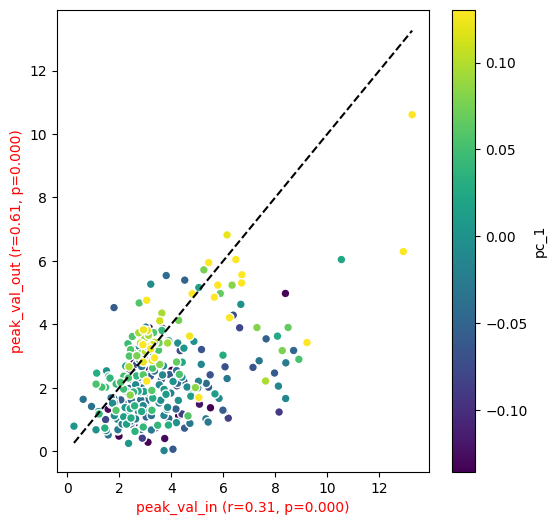

In [164]:
color_code = 'pc_1'


# Create jointplot (it creates its own figure)
fig = plt.figure(figsize=(6, 6))
sort_ind = np.argsort(results_df[color_code].values)
# sort_ind = np.random.permutation(sort_ind)  # shuffle to prevent overplotting bias
x_val = 'peak_val_in'
y_val = 'peak_val_out'
g = plt.scatter(results_df[x_val][sort_ind], results_df[y_val][sort_ind], alpha=1, edgecolors='w', 
                c=results_df[color_code][sort_ind], cmap='viridis', s = 40,
                vmin=np.nanquantile(results_df[color_code].values, 0.05), vmax=np.nanquantile(results_df[color_code].values, 0.95))
plt.plot([results_df[x_val].min(), results_df[x_val].max()], [results_df[x_val].min(), results_df[x_val].max()], 'k--')
plt.colorbar(g, label=color_code)
# check if x and y correlate with colorcode. label on x and y axis
filter = ~np.isnan(results_df[x_val]) & ~np.isnan(results_df[color_code])& ~np.isnan(results_df[y_val])

corr_x = pearsonr(results_df[x_val][filter], results_df[color_code][filter])
corr_y = pearsonr(results_df[y_val][filter], results_df[color_code][filter])

# calculate p value

p_x = pearsonr(results_df[x_val][filter], results_df[color_code][filter])[1]
p_y = pearsonr(results_df[y_val][filter], results_df[color_code][filter])[1]

if p_x < 0.05:
    plt.xlabel(f'{x_val} (r={corr_x[0]:.2f}, p={p_x:.3f})', color='red')
else:
    plt.xlabel(f'{x_val} (r={corr_x[0]:.2f}, p={p_x:.3f})', color='black')

if p_y < 0.05:
    plt.ylabel(f'{y_val} (r={corr_y[0]:.2f}, p={p_y:.3f})', color='red')
else:
    plt.ylabel(f'{y_val} (r={corr_y[0]:.2f}, p={p_y:.3f})', color='black')



<Figure size 1000x1000 with 0 Axes>

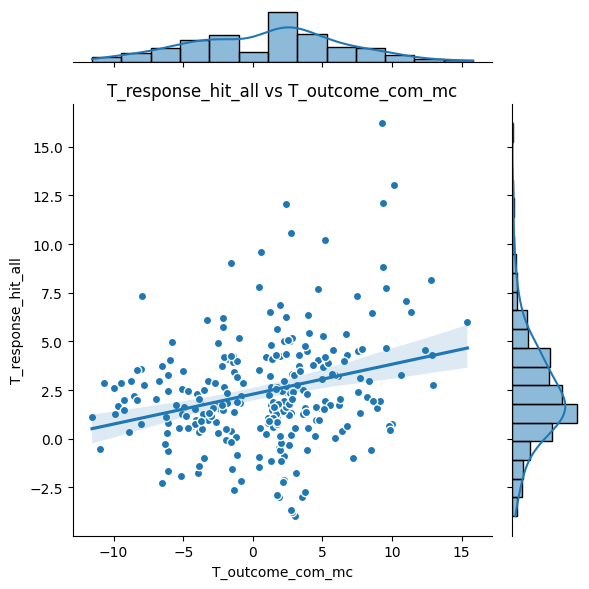

In [167]:
fig = plt.figure(figsize=(10, 10))
x_val = 'T_outcome_com_mc'
y_val = 'T_response_hit_all'
# diagonal line
g = sns.jointplot(x=x_val, y=y_val, data=results_df, kind='reg', scatter_kws={'alpha':1, 'edgecolors':'w'})
# add diagonal line
# g.ax_joint.plot([results_df[x_val].min(), results_df[x_val].max()], [results_df[x_val].min(), results_df[x_val].max()], 'k--')
# plt.plot([results_df['peak_val_out'].min(), results_df['peak_val_out'].max()], [results_df['peak_val_out'].min(), results_df['peak_val_out'].max()], 'k--')
g.set_axis_labels(x_val, y_val)
plt.title(f'{y_val} vs {x_val}')
plt.tight_layout()
# save svg
plt.savefig(os.path.join(target_folder, f'{y_val} and {x_val} comparison_{criteria_name}.svg'), bbox_inches='tight', dpi=300)

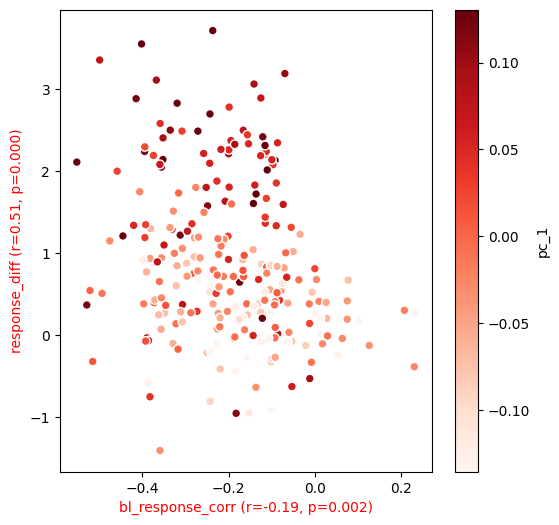

In [166]:
color_code = 'pc_1'

# Create jointplot (it creates its own figure)
fig = plt.figure(figsize=(6, 6))
sort_ind = np.argsort(results_df[color_code].values)[::-1]
sort_ind = np.random.permutation(sort_ind)  # shuffle to prevent overplotting bias
x_val = 'bl_response_corr'
y_val = 'response_diff'
g = plt.scatter(results_df[x_val][sort_ind], results_df[y_val][sort_ind], alpha=1, edgecolors='w', 
                c=results_df[color_code][sort_ind], cmap='Reds', s = 40,
                vmin=np.nanquantile(results_df[color_code].values, 0.05), vmax=np.nanquantile(results_df[color_code].values, 0.95))
# plt.plot([results_df[x_val].min(), results_df[x_val].max()], [results_df[x_val].min(), results_df[x_val].max()], 'k--')
plt.colorbar(g, label=color_code)
# check if x and y correlate with colorcode. label on x and y axis
filter = ~np.isnan(results_df[x_val]) & ~np.isnan(results_df[color_code]) & ~np.isnan(results_df[y_val])

corr_x = pearsonr(results_df[x_val][filter], results_df[color_code][filter])
corr_y = pearsonr(results_df[y_val][filter], results_df[color_code][filter])

# calculate p value

p_x = pearsonr(results_df[x_val][filter], results_df[color_code][filter])[1]
p_y = pearsonr(results_df[y_val][filter], results_df[color_code][filter])[1]

if p_x < 0.05:
    plt.xlabel(f'{x_val} (r={corr_x[0]:.2f}, p={p_x:.3f})', color='red')
else:
    plt.xlabel(f'{x_val} (r={corr_x[0]:.2f}, p={p_x:.3f})', color='black')

if p_y < 0.05:
    plt.ylabel(f'{y_val} (r={corr_y[0]:.2f}, p={p_y:.3f})', color='red')
else:
    plt.ylabel(f'{y_val} (r={corr_y[0]:.2f}, p={p_y:.3f})', color='black')


In [151]:
# use k3d to plot interactive 3d 
mask = np.ones(len(results_df), dtype=bool)

# --- Anatomical coordinates ---
ccfs = results_df[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml = 0
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for feature in features_to_plot:
    color = results_df[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize color range to [0, 1] ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list(
            'bwr_custom', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg)) / (amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list('wr_custom', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Sort for proper rendering ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]

    # === Map to RGBA, inject alpha ===
    rgba = custom_cmap(color_reg_plot)
    # rgba[:, -1] = alpha_scale_plot
    rgb = (rgba[:, :3] * 255).astype(np.uint32)
    colors = (rgb[:, 0] << 16) + (rgb[:, 1] << 8) + rgb[:, 2]

    # --- Create interactive K3D plot ---
    plt_3d = k3d.plot(
        camera_auto_fit=True,
        background_color=0x000000,
        grid_visible=False
    )

    # --- Optional: anatomical mesh if available ---
    if 'mesh_vertices_mm' in locals() and 'mesh' in locals():
        faces = np.array(mesh.faces).astype(np.uint32)
        plt_3d += k3d.mesh(
            mesh_vertices_mm.astype(np.float32),
            faces,
            color=0x888888,
            opacity=0.1
        )

    # # --- Scatter points with per-point alpha ---
    # pts = k3d.points(
    #     positions=ccfs_plot.astype(np.float32),
    #     colors=colors.astype(np.uint32),
    #     point_size=0.05,
    #     shader='3d',
    #     opacity=1.0
    # )
    # only plot those not NaN
    for ind in range(len(ccfs_plot)):
        if np.isnan(color_reg_plot[ind]):
            continue
        pt = k3d.points(
            positions=ccfs_plot[ind:ind+1].astype(np.float32),
            colors=np.array([colors[ind]]).astype(np.uint32),
            point_size=0.05,
            shader='3d',
            # opacity=alpha_scale_plot[ind]
            opacity = 0.6,
        )
        plt_3d += pt

    # --- Add colorbar (sample colormap directly) ---
    color_map_for_bar = np.array(
        [custom_cmap(i / 255)[:3] for i in range(256)],
        dtype=np.float32
    )

    # plt_3d += k3d.color_map.ColorMap(
    #     color_map=color_map_for_bar,
    #     color_range=[np.nanmin(color), np.nanmax(color)],
    #     label=feature,
    #     position_x=0.02,
    #     position_y=0.85,
    #     width=0.015,
    #     height=0.5
    # )

    # --- Save to HTML ---
    html_path = os.path.join(target_folder, '3D_links',f'k3d_{feature}_3D.html')
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    with open(html_path, 'w') as f:
        f.write(plt_3d.get_snapshot())

    print(f"✅ Saved interactive plot: {html_path}")


✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_pca_in_1_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_pca_in_2_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_pca_out_1_3D.html


✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_pca_out_2_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_cca_in_1_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_cca_out_1_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_pca_out_video_1_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_pca_out_video_2_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_peak_val_in_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_peak_val_out_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_peak_val_out_video_3D.html
✅ Saved interactive plot: /root/capsule/scratch/manuscript/F_lick_compare/3D_links/k3d_peak_lat_in_3D.html
✅ Saved interactive plot: /r